In [343]:


import jax
import jax.numpy as jnp
import pandas as pd
from jax.tree_util import Partial
from liesel_sparse import band

jax.config.update("jax_enable_x64", True)


### Kernels


def RBFKernel(sigma_f, length, x, y):
    return (
            sigma_f * jnp.exp(-(jnp.linalg.norm(x - y) ** 2) / (2 * length ** 2))
    ).astype(float)


def ExpSineSquaredKernel(sigma_f, length, periodictiy, x, y):
    return (
            sigma_f
            * jnp.exp(
        -2 * (jnp.sin(jnp.pi * jnp.linalg.norm(x - y) / periodictiy) / length) ** 2
    )
    ).astype(float)


def MaternKernel32(sigma_f, length_scale, x, y):
    arg = jnp.sqrt(3) * jnp.linalg.norm(x - y) / length_scale
    return (sigma_f * (1 + arg) * jnp.exp(-arg)).astype(float)


def MaternKernel52(sigma_f, length_scale, x, y):
    arg = jnp.sqrt(5) * jnp.linalg.norm(x - y) / length_scale
    return (sigma_f * (1 + arg + jnp.square(arg) / 3) * jnp.exp(-arg)).astype(float)


def ABDKernel(sigma_f, length_scale, x, y):
    return sigma_f * jnp.exp(
        -jnp.linalg.norm(x / length_scale - y / length_scale)
    ).astype(float)


def SphericalTapering(theta, x, y):
    # Valid taper for Matern v <= 0.5
    r = jnp.linalg.norm(x - y) / theta
    return jnp.maximum(0, 1 - r)


def WendlandTapering(theta, x, y):
    # Valid taper for Matern v <= 2.5
    # d = 1, k = 2
    r = jnp.linalg.norm(x - y) / theta
    return jnp.maximum(0, 1 - r) ** 5 * (8 * r * r * 5 * r + 1)


### Implementation


#@jax.jit
def cov_matrix(x1, x2, cov_function):
    # Returns the symmetric kernel matrix K.
    K = jax.vmap(lambda x_: jax.vmap(lambda y_: cov_function(x_, y_))(x1))(x2)

    return K


#@functools.partial(jax.jit, static_argnames=["kernel_"])
def log_likelihood(kernel_, params, data_x, data_y, eps):
    # Compute the negative marginal log likelihood.
    Lb, alpha = inv_cov_chol(Partial(kernel_, *params), data_x, data_y, eps)

    return -(
            -0.5 * jnp.dot(data_y, alpha)
            - (jnp.log(Lb[0])).sum()
            - 0.5 * alpha.shape[0] * jnp.log(2 * jnp.pi)
    )


#@jax.jit
def inv_cov_chol(cov_f, data_x, data_y, eps):
    # Get Kernel and add noise.
    K = cov_matrix(data_x, data_x, cov_f)

    # TAPERING V1
    # Ktaper = cov_matrix(data_x, data_x, Partial(WendlandTapering, 10))
    jax.debug.print(str(jnp.count_nonzero(K)) + "/" + str(K.shape[0]**2))
    # K = K * Ktaper
    # jax.debug.print("to" + str(jnp.count_nonzero(K)))

    # TAPERING V0
    # K = jnp.where(K < 1e-5, 0, K)

    K = K.at[jnp.diag_indices_from(K)].add(eps)

    _, idx = band.permute(K)

    # O(N²) Memory Overhead!
    P = np.eye(len(idx))[idx]
    Kp = P @ K @ P.T

    p = int(band.bandwidth(Kp))
    jax.debug.print(str(p) + "/" + str(K.shape[0]))
    Kpb = band.to_band(Kp, p)  # TODO: bandwidth

    Lb = band.cholesky_band(Kpb)
    alpha = P.T @ band.solve_band(Lb, data_y[idx])

    return Lb, alpha


class GPR:
    def __init__(self, data_x, data_y, kernel_, params, eps=1e-10):
        self.data_x = data_x
        self.data_y = data_y
        self.kernel_ = kernel_
        self.covariance_function = Partial(kernel_, *params)  # ??
        self.params = params
        self.eps = eps

        self.Lb_ = None
        self.alpha_ = None
        self.idx = None
        #self.log_marginal_likelihood_value_ = log_likelihood(
        #    self.kernel_, self.params, self.data_x, self.data_y, self.eps
        #)

    # Function to predict output at new input values.
    def predict(self, at_values, return_std=False):
        if self.alpha_ is None:
            # Compute values needed for prediction after fit.
            self.Lb_, self.alpha_ = inv_cov_chol(
                self.covariance_function, self.data_x, self.data_y, self.eps
            )

        K_trans = cov_matrix(self.data_x, at_values, self.covariance_function)
        y_mean = K_trans @ self.alpha_

        if return_std:
            V = jax.scipy.linalg.solve_triangular(band.to_ltri_full(self.Lb_), K_trans.T, lower=True)
            y_var = jnp.diag(cov_matrix(at_values, at_values, self.covariance_function))
            y_var -= jnp.einsum("ij,ji->i", V.T, V)
            y_var = y_var.at[jnp.argwhere(y_var < 0)].set(0)

            return y_mean, jnp.sqrt(y_var)
        return y_mean

    # def fit(self):
    #     import optax
    #
    #     def get_update_fn(optimizer):
    #         def update(params, opt_state):
    #             grads = jax.grad(Partial(log_likelihood, self.kernel_))(params, self.data_x, self.data_y)  # ?
    #             updates, opt_state = optimizer.update(grads, opt_state, params=params)
    #             params = optax.apply_updates(params, updates)
    #             return params, opt_state
    #
    #         return jax.jit(update)
    #
    #     optimizer = optax.sgd(learning_rate=3e-3)
    #
    #     params = self.params
    #     opt_state = optimizer.init(params)
    #     update_f = get_update_fn(optimizer)
    #
    #     for j in range(1000):
    #         params, opt_state = update_f(params, opt_state)
    #
    #     self.params = params
    #     self.covariance_function = Partial(self.kernel_, *params)

    def fit(self):
        # Use BFGS for Gradient Descent to optimize mll.
        # Only one (Unbounded) run is performed.
        import jaxopt

        def fwd(*args, **kwargs):
            return Partial(log_likelihood, self.kernel_)(*args, **kwargs), \
                jax.jacfwd(Partial(log_likelihood, self.kernel_))(*args, **kwargs)

        solver = jaxopt.LBFGS(
            fun=fwd,
            value_and_grad=True,
            maxiter=500,
            stepsize=1e-4,
            tol=1e-2,
        )

        print(f"Starting solve...")

        soln = solver.run(
            self.params, data_x=self.data_x, data_y=self.data_y, eps=self.eps
        )

        params, state = soln
        print(f"Final solve: {state.value=} at {params}")
        print(f"Iter: {state.iter_num=}")

        # Precompute quantities required for predictions which are independent
        # of actual query points
        self.params = jnp.where(params > 0, params, 1e-5)
        self.covariance_function = Partial(self.kernel_, *self.params)
        self.log_marginal_likelihood_value_ = log_likelihood(
            self.kernel_, self.params, self.data_x, self.data_y, self.eps
        )
        self.alpha_ = None

## Compare
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy_targets.html

In [382]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.RandomState(2)


# Toy data, Weibull
def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)


X = np.linspace(start=0, stop=10, num=1000).reshape(-1, 1)
lam = 1 / 5
k = 3.5
y = np.squeeze(weibull_F(X, lam, k) + rng.normal(scale=0.1 ** 2, size=X.shape))
estimated_y = np.squeeze(weibull_F(X, 1 / 4, 3.8))
y -= estimated_y

training_indices = rng.choice(np.arange(y.size), size=300, replace=False)
X_train, y_train = X[training_indices], y[training_indices]

# Observation Noise
noise_std = 0.01
y_train = y_train + rng.normal(loc=0, scale=noise_std, size=y_train.shape)

# Parameters
#[0.02970224 1.20957201 0.04      ]
s = 0.1
l = 10
p = 0

theta_init = jnp.array([s, l, p], dtype=float)

-769.8418807952341 at 0.316**2 * Matern(length_scale=10, nu=1.5)
---
16872/90000
38/300


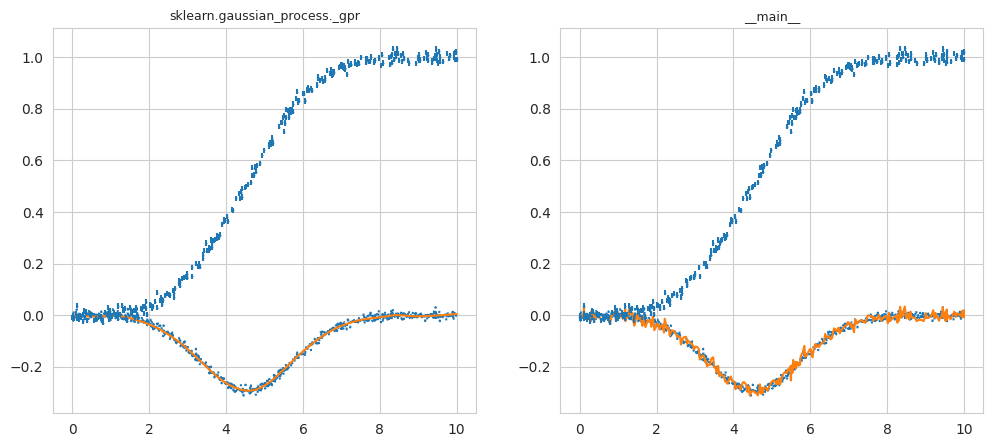

In [383]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, ax in enumerate(axs.flatten()):
    if i == 0:
        kernel = s * Matern(l, nu=3 / 2)
        gaussian_process = GaussianProcessRegressor(
            kernel=kernel,
            alpha=noise_std ** 2, optimizer=None
        )
        gaussian_process.fit(X_train, y_train)
        print(-gaussian_process.log_marginal_likelihood_value_, "at", gaussian_process.kernel_)
        print("---")
    else:
        def kernel(s1, l1, p1, x, y):
            return MaternKernel32(s1, l1, x, y) * WendlandTapering(1, x, y)

        gaussian_process = GPR(X_train, y_train, kernel, theta_init, eps=noise_std ** 2)
        #gaussian_process.fit()

    #mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)
    mean_prediction = gaussian_process.predict(X)
    #mean_prediction += estimated_y
    ax.plot(X, y, linestyle="dotted") # + estimated_y
    ax.plot(X, mean_prediction, label="Mean prediction")
    ax.errorbar(
        X_train,
        y_train + estimated_y[training_indices],
        noise_std,
        markersize=.7,
        linestyle="None",
        color="tab:blue",
        marker=".",
        label="Observations",
    )
    # ax.fill_between(
    #     X.ravel(),
    #     mean_prediction - 1.96 * std_prediction,
    #     mean_prediction + 1.96 * std_prediction,
    #     alpha=0.3,
    #     color="tab:orange",
    # )
    ax.set_title(gaussian_process.__module__, fontsize=9)
# [ 0.12348134 -1.10319809  0.21209229 -0.58400622 -0.90968804 -0.69136815
#   0.85221527 -0.54826795 -1.2851047   0.20891352]
plt.show()

# Band

In [8]:
from liesel_sparse import band
import jax
import numpy as np

rng = np.random.RandomState(1)
A = rng.random((3, 3))
A = A @ A.T

f = lambda x: jax.numpy.linalg.cholesky(x).sum()
fgrad1 = jax.grad(f)(A)

Ab = band.to_band(A, int(band.bandwidth(A)))
f = lambda x: band.cholesky_band(x).sum()

fgrad2b = jax.jacfwd(f)(Ab).at[1:].divide(2)
fgrad2 = band.to_symm_full(fgrad2b)

print(fgrad1)
print(fgrad2)
assert jnp.allclose(fgrad1, fgrad2)

[[ 0.98815422 -0.47079403 -0.48761319]
 [-0.47079403  1.36602511  1.30320249]
 [-0.48761319  1.30320249  1.38345787]]
[[ 0.98815422 -0.47079403 -0.48761319]
 [-0.47079403  1.36602511  1.30320249]
 [-0.48761319  1.30320249  1.38345787]]


In [44]:
rhs = rng.random((3,))


def kernel(s1, l1, p1, x, y):
    return MaternKernel52(s1, l1, x, y)


def f(params, data_x, data_y, eps):
    # Compute the negative marginal log likelihood.
    K = cov_matrix(data_x, data_x, Partial(kernel, *params))
    K = K.at[jnp.diag_indices_from(K)].add(eps)

    # Solve Kα=y using the Cholesky decomposition.
    L = jax.lax.linalg.cholesky(K)
    alpha = jax.lax.linalg.triangular_solve(
        L.T,
        jax.lax.linalg.triangular_solve(L, data_y, left_side=True, lower=True),
        left_side=True,
    )

    return -(
            -0.5 * jnp.dot(data_y, alpha)
            - (jnp.log(jnp.diag(L))).sum()
            - 0.5 * L.shape[0] * jnp.log(2 * jnp.pi)
    )


print(
    jax.grad(f)(theta_init, X_train, y_train, 0.2)
)
print("-------------")

print(
    jax.jacfwd(Partial(log_likelihood, kernel))(theta_init, X_train, y_train, 0.2)
)

[-10.34842302  12.77663453   0.        ]
-------------
[-10.34842302  12.77663453   0.        ]


In [334]:
import scipy.sparse as ssp

A = ssp.random(5,5,.2, ).todense()
A = A @ A.T + 0.001 * jnp.eye(5)
b = jnp.squeeze(ssp.random(5,1, 1, random_state=5).todense())

idx = ssp.csgraph.reverse_cuthill_mckee(ssp.csr_matrix(A), symmetric_mode=True)
print("idx", idx)
#print("A", A)

P = np.eye(len(idx))[idx]

print("real", jnp.linalg.solve(A, b))
print("perm", jnp.linalg.solve(P @ A, b[idx]))

Ap = A.copy()
Ap = Ap.at[:,:].set(Ap[idx, :])
Ap = Ap.at[:,:].set(Ap[:, idx])

#Ap = P @ A @ P.T
Apb = band.to_band(Ap, int(band.bandwidth(Ap)))
Lb = band.cholesky_band(Apb)
alpha = P.T @ band.solve_band(Lb, b[idx])

#alpha = P.T @ jnp.linalg.solve(Ap, P @ b)

print("alpha", alpha)
print(jnp.allclose(A @ alpha, b))

idx [4 3 2 1 0]
real [ 9.79444999e+02  8.98210377e+01  2.05126766e+02 -8.72574936e+01
 -6.07183724e-01]
perm [ 9.79444999e+02  8.98210377e+01  2.05126766e+02 -8.72574936e+01
 -6.07183724e-01]
alpha [ 9.79444999e+02  8.98210377e+01  2.05126766e+02 -8.72574936e+01
 -6.07183724e-01]
True
